In [1]:
from openai import OpenAI
import json
import pandas as pd
from jinja2 import Template
from tqdm import tqdm
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from typing import Union


plt.rcParams.update({'font.size': 13})

# Model Selection

In [2]:
model_name = "gpt-4o-mini"
# model_name = "gpt-4-turbo"
# model_name = "gemma2-9b-it"
# model_name = "gpt-4o"
# model_name = "llama3-8b-8192"
# model_name = "llama-3.1-8b-instant"

In [3]:
normal_results_path = f"results/{model_name}_normal_0_20_results.json"
distractors_result_path = f"results/{model_name}_distractors_0_20_results.json"

In [4]:
with open(normal_results_path, 'r') as f:
    normal_results = json.load(f)

with open(distractors_result_path, 'r') as f:
    distractors_result = json.load(f)

In [5]:
len(normal_results), len(distractors_result)

(20, 20)

In [6]:
def get_color_from_cmap(value: float, group_name: str) -> Union[str, None]:
    if 0 <= value <= 1:
        try:
            cmap = plt.get_cmap(group_name)
            rgba = cmap(value)
            hex_color = mcolors.rgb2hex(rgba)
            return hex_color
        except ValueError:
            print(f"Colormap '{group_name}' is not recognized.")
            return None
    else:
        print("Value should be between 0 and 1.")
        return None
    
colors_for_datasets = [get_color_from_cmap(i, 'plasma') for i in [0.1, 0.35, 0.65, 0.9]]
colors_for_datasets

['#41049d', '#a11b9b', '#ea7457', '#fcce25']

# Reliability Diagram

In [7]:
def plot_calibration_diagram(json_data1, json_data2):
    def extract_confidences_and_accuracies(json_data):
        # Load JSON data if it's a string
        if isinstance(json_data, str):
            json_data = json.loads(json_data)
        
        confidences = []
        accuracies = []
        
        # Extract confidence and correctness
        for key, value in json_data.items():
            if value["output"] != -1:
                confidences.append(value["confidence"])
                accuracies.append(value["output"])
        
        return np.array(confidences), np.array(accuracies)
    
    confidences1, accuracies1 = extract_confidences_and_accuracies(json_data1)
    confidences2, accuracies2 = extract_confidences_and_accuracies(json_data2)
    bins = np.arange(0, 101, 10)  # Bins from 0 to 100 in steps of 10
    bin_centers = (bins[:-1] + bins[1:]) / 2

    
    counts1, _ = np.histogram(confidences1[accuracies1 == 1], bins=bins)
    counts2, _ = np.histogram(confidences2[accuracies2 == 1], bins=bins)
    counts = np.array([counts1, counts2])

    def calculate_actual_accuracy(confidences, accuracies):
        actual_accuracy = []
        for i in range(len(bins) - 1):
            mask = (confidences >= bins[i]) & (confidences < bins[i + 1])
            if np.sum(mask) > 0:
                actual_accuracy.append(np.mean(accuracies[mask]))
            else:
                actual_accuracy.append(0)  # Use 0 for empty bins to avoid NoneType issues
        return actual_accuracy
    
    # plt.rcParams['font.family'] = 'Times New Roman'
    
    # Add values on top of histogram bars
    actual_accuracy1 = calculate_actual_accuracy(confidences1, accuracies1)
    actual_accuracy2 = calculate_actual_accuracy(confidences2, accuracies2)
    
    for i, count in enumerate(counts1):
        if count > 0:
            plt.text(bin_centers[i] - 2, actual_accuracy1[i] + 0.05, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold', rotation=90, bbox=dict(facecolor='black', edgecolor='black', alpha=1.0), color='white')
    for i, count in enumerate(counts2):
        if count > 0:
            plt.text(bin_centers[i] + 2, actual_accuracy2[i] + 0.05, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold', rotation=90, bbox=dict(facecolor='black', edgecolor='black', alpha=1.0), color='white')
    
    sns.set(style="whitegrid")
    colors_for_datasets = [get_color_from_cmap(i, 'plasma') for i in [0.1, 0.35, 0.65, 0.9]]
    plt.bar(bin_centers - 2, actual_accuracy1, width=4, color=colors_for_datasets[1], label='Original', edgecolor='black', hatch='xx')
    plt.bar(bin_centers + 2, actual_accuracy2, width=4, color=colors_for_datasets[3], label='Distractors', edgecolor='black', hatch='o')
    plt.plot([0, 100], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
    # plt.xlabel('Predicted Confidence (%)', fontsize=14, fontweight='bold')
    # plt.ylabel('Actual Accuracy', fontsize=14, fontweight='bold')
    plt.title(f'{model_name}', fontsize=18, family='Times New Roman')
    plt.xticks(fontsize=16, family='Times New Roman')
    plt.yticks(fontsize=16, family='Times New Roman')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Print x dotted line after each 10 point interval
    for x in range(10, 101, 10):
        plt.axvline(x=x, color='black', linestyle=':', linewidth=1)
    
    # plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    
    # Create a solid black border around the chart
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['top'].set_color('black')
    plt.gca().spines['right'].set_linewidth(0.5)
    plt.gca().spines['right'].set_color('black')
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_color('black')

    # save pdf 
    plt.savefig(f'figures/{model_name}.pdf', format='pdf', dpi=300)
    
    plt.show()

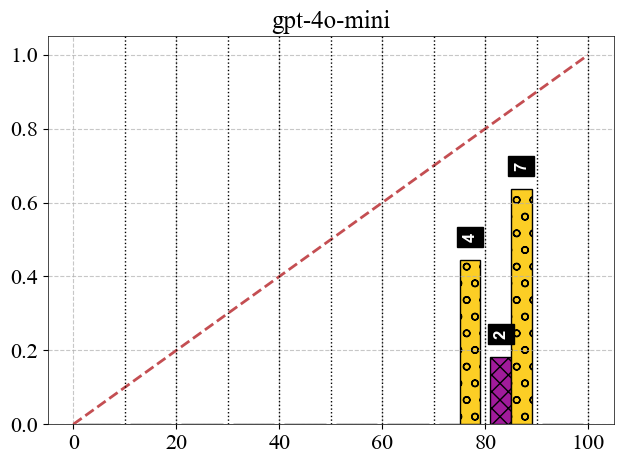

In [8]:
plot_calibration_diagram(normal_results, distractors_result)

# Accuracy

In [9]:
correct_1 = 0
correct_2 = 0
none_1 = 0


wrong_1 = 0
wrong_2 = 0
none_2 = 0

for key, value in normal_results.items():
    if value["output"] == 1:
        correct_1 += 1
    elif value["output"] == 0:
        wrong_1 += 1
    elif value["output"] == -1:
        none_1 += 1

for key, value in distractors_result.items():
    if value["output"] == 1:
        correct_2 += 1
    elif value["output"] == 0:
        wrong_2 += 1
    elif value["output"] == -1:
        none_2 += 1

print("Total correct predictions for original model:", correct_1)
print("Total correct predictions for distractors model:", correct_2)
print("--------------------------------")
print("Total wrong predictions for original model:", wrong_1)
print("Total wrong predictions for distractors model:", wrong_2)
print("--------------------------------")
print("Total none predictions for original model:", none_1)
print("Total none predictions for distractors model:", none_2)
print("--------------------------------")
print("Accuracy of original model:", round((correct_1 / len(normal_results)) * 100, 2), "%")
print("Accuracy of distractors model:", round((correct_2 / len(distractors_result)) * 100, 2), "%")
print("--------------------------------")
print("Accuracy of no predictions for original model:", round((none_1 / len(normal_results)) * 100, 2), "%")
print("Accuracy of no predictions for distractors model:", round((none_2 / len(distractors_result)) * 100, 2), "%")

Total correct predictions for original model: 2
Total correct predictions for distractors model: 11
--------------------------------
Total wrong predictions for original model: 17
Total wrong predictions for distractors model: 9
--------------------------------
Total none predictions for original model: 1
Total none predictions for distractors model: 0
--------------------------------
Accuracy of original model: 10.0 %
Accuracy of distractors model: 55.0 %
--------------------------------
Accuracy of no predictions for original model: 5.0 %
Accuracy of no predictions for distractors model: 0.0 %


# ECE plot

In [10]:
def calculate_ece(probabilities, predictions, bin_width=10):
    """
    Calculate Expected Calibration Error (ECE) given probabilities and predictions.
    
    :param probabilities: List of predicted probabilities (in percentage, 0-100 scale).
    :param predictions: List of binary correctness labels (1 if correct, 0 if incorrect).
    :param bin_width: Width of probability bins (default is 10).
    :return: ECE value.
    """
    probabilities = np.array(probabilities) / 100.0  # Convert to 0-1 scale
    predictions = np.array(predictions)
    
    bins = np.arange(0, 1.1, bin_width / 100.0)  # Define bins from 0 to 1
    bin_indices = np.digitize(probabilities, bins) - 1  # Find bin indices
    
    ece = 0.0
    total_samples = len(probabilities)

    for i in range(len(bins) - 1):
        bin_mask = bin_indices == i
        bin_size = np.sum(bin_mask)

        if bin_size > 0:
            accuracy = np.mean(predictions[bin_mask])
            confidence = np.mean(probabilities[bin_mask])
            bin_weight = bin_size / total_samples
            ece += bin_weight * abs(accuracy - confidence)

    return ece

In [11]:
print(len(normal_results), len(distractors_result))

20 20


In [12]:
normal_results_confidence = []
normal_results_predictions = []

for key, value in normal_results.items():
    normal_results_confidence.append(value["confidence"])
    normal_results_predictions.append(value["output"])

ece_value = calculate_ece(normal_results_confidence, normal_results_predictions)
print("ECE for original model:", round(ece_value, 3))

distractors_results_confidence = []
distractors_results_predictions = []

for key, value in distractors_result.items():
    distractors_results_confidence.append(value["confidence"])
    distractors_results_predictions.append(value["output"])

ece_value = calculate_ece(distractors_results_confidence, distractors_results_predictions)
print("ECE for distractors model:", round(ece_value, 3))

ECE for original model: 0.705
ECE for distractors model: 0.283


# D_helped and D_harmed

In [13]:
if len(normal_results) != len(distractors_result):
    raise ValueError("Normal results should not be greater than distractors results")

In [14]:
d_helped_count = 0
d_hurt_count = 0

from tqdm import tqdm

for i in tqdm(range(len(normal_results))):
    try:
        normal_output_value = normal_results[str(i)]["output"]
        distractors_output_value = distractors_result[str(i)]["output"]
    except:
        continue
    # if D helped
    if normal_output_value == 0 and distractors_output_value == 1:
        d_helped_count += 1

    # if D hurt
    if normal_output_value == 1 and distractors_output_value == 0:
        d_hurt_count += 1

print("D helped count:", d_helped_count)
print("D hurt count:", d_hurt_count)

print("D helped percentage:", round((d_helped_count / (d_helped_count + d_hurt_count)) * 100, 2), "%")
print("D hurt percentage:", round((d_hurt_count / (d_helped_count + d_hurt_count)) * 100, 2), "%")


100%|██████████| 20/20 [00:00<00:00, 234975.01it/s]

D helped count: 10
D hurt count: 1
D helped percentage: 90.91 %
D hurt percentage: 9.09 %
